### 1D Burger's equation

$u_t + uu_{x} - (0.01/\pi)u_{xx}, x\in[-1, 1], t\in[0, 1]$

$u(0, x) = -\sin(\pi x),$

$u(t, -1)=u(t, 1)=0$

**The aim is to solve the 1D Burger's equation**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../py-pde/')

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
from copy import deepcopy

from utils import *
from models import *

### Solve PDE with finite difference using py-pde 

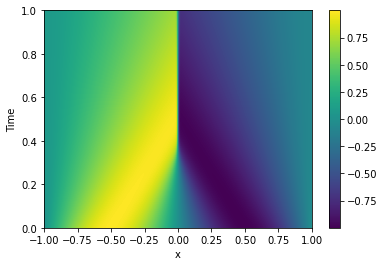

In [2]:
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, ExplicitSolver

class Burger1D(PDEBase):
    def __init__(self, bc):
        super(Burger1D, self).__init__()
        self.bc = bc
    def evolution_rate(self, u, t=0):
        assert u.grid.dim == 1
        u_x = u.gradient("natural")[0]
        return -u*u_x+(0.01/np.pi)*u.laplace("natural")
    
Nx = 1000
grid = CartesianGrid([[-1, 1]], [Nx], periodic=False)
u = ScalarField.from_expression(grid, "-sin(pi*x)")

storage = MemoryStorage()
eq = Burger1D(bc={"value": 0.0})
eq.solve(u, t_range=1, tracker=storage.tracker(0.01), dt=1e-4)

plot_kymograph(storage)

In [3]:
# reshape the output, create solution for evaluation of PINN's solution
xb = grid.axes_bounds[0]
x = np.linspace(*xb, grid.shape[0]+2)
t = np.array(storage.times)
x_mesh, t_mesh = np.meshgrid(x[1:-1], t)
sol_u = torch.from_numpy(np.concatenate(storage.data)).float().reshape(-1, 1)
sol_t = torch.from_numpy(t_mesh.reshape(-1, 1)).float()
sol_x = torch.from_numpy(x_mesh.reshape(-1, 1)).float()

### Case 1: with fixed samples of initial, boundary and interior points.

In [4]:
# defnitions
activation = torch.tanh
n_hidden = 5
n_nodes = 5

N_init, N_bc, N_pde = 50, 50, 5000

max_epochs = 15001
mse_loss = torch.nn.MSELoss()

In [5]:
torch.manual_seed(777)
net0 = TimeDependentFFN(activation, n_hidden, n_nodes, inputs=1).to(device)
initial_state =deepcopy(net0.state_dict())

model0 = Burger1DNN(N_init, N_bc, N_pde, net0, device)
optimizer = torch.optim.Adam(net0.parameters())

callbacks = []
callbacks.append(ResamplingHandler(model0, sampling_rate=max_epochs*2))
pde_errors0 = []
callbacks.append(ValueTracker(name='training loss', values=pde_errors0))
u_errors0 = []
callbacks.append(ValidationErrorTracker(model0, mse_loss, 
                                        (sol_x, sol_t, sol_u), errors=u_errors0))
callbacks.append(DiagnosticVerbose(trainer=model0, print_rate=1000, 
                              values={'pde error': pde_errors0, 'solution error': u_errors0}))

In [6]:
# train the model
model0.train(optimizer, mse_loss, max_epochs, callbacks)

At epoch 0: pde error: 0.4819; solution error: 0.3791; 
At epoch 1000: pde error: 0.1002; solution error: 0.0995; 
At epoch 2000: pde error: 0.0422; solution error: 0.0566; 
At epoch 3000: pde error: 0.0240; solution error: 0.0409; 
At epoch 4000: pde error: 0.0134; solution error: 0.0267; 
At epoch 5000: pde error: 0.0085; solution error: 0.0245; 
At epoch 6000: pde error: 0.0069; solution error: 0.0206; 
At epoch 7000: pde error: 0.0061; solution error: 0.0200; 
At epoch 8000: pde error: 0.0055; solution error: 0.0199; 
At epoch 9000: pde error: 0.0051; solution error: 0.0202; 
At epoch 10000: pde error: 0.0048; solution error: 0.0200; 
At epoch 11000: pde error: 0.0046; solution error: 0.0201; 
At epoch 12000: pde error: 0.0044; solution error: 0.0201; 
At epoch 13000: pde error: 0.0042; solution error: 0.0200; 
At epoch 14000: pde error: 0.0041; solution error: 0.0201; 
At epoch 15000: pde error: 0.0040; solution error: 0.0199; 


### Case 2: resample every ? epoches.

In [7]:
resample_period = 20

net1 = TimeDependentFFN(activation, n_hidden, n_nodes, inputs=1).to(device)
net1.load_state_dict(initial_state)
model1 = Burger1DNN(N_init, N_bc, N_pde, net1, device)
optimizer = torch.optim.Adam(net1.parameters())

callbacks = []
callbacks.append(ResamplingHandler(model1, sampling_rate=resample_period))
pde_errors1 = []
callbacks.append(ValueTracker(name='training loss', values=pde_errors1))
u_errors1 = []
callbacks.append(ValidationErrorTracker(model1, mse_loss, 
                                        (sol_x, sol_t, sol_u), errors=u_errors1))
callbacks.append(DiagnosticVerbose(trainer=model1, print_rate=1000, 
                              values={'pde error': pde_errors1, 'solution error': u_errors1}))

In [8]:
model1.train(optimizer, mse_loss, max_epochs, callbacks)

At epoch 0: pde error: 0.4146; solution error: 0.3791; 
At epoch 1000: pde error: 0.1406; solution error: 0.0919; 
At epoch 2000: pde error: 0.1189; solution error: 0.0775; 
At epoch 3000: pde error: 0.1052; solution error: 0.0677; 
At epoch 4000: pde error: 0.0833; solution error: 0.0553; 
At epoch 5000: pde error: 0.0607; solution error: 0.0323; 
At epoch 6000: pde error: 0.0399; solution error: 0.0264; 
At epoch 7000: pde error: 0.0301; solution error: 0.0273; 
At epoch 8000: pde error: 0.0267; solution error: 0.0294; 
At epoch 9000: pde error: 0.0200; solution error: 0.0080; 
At epoch 10000: pde error: 0.0173; solution error: 0.0045; 
At epoch 11000: pde error: 0.0143; solution error: 0.0086; 
At epoch 12000: pde error: 0.0142; solution error: 0.0113; 
At epoch 13000: pde error: 0.0134; solution error: 0.0072; 
At epoch 14000: pde error: 0.0118; solution error: 0.0029; 
At epoch 15000: pde error: 0.0104; solution error: 0.0044; 


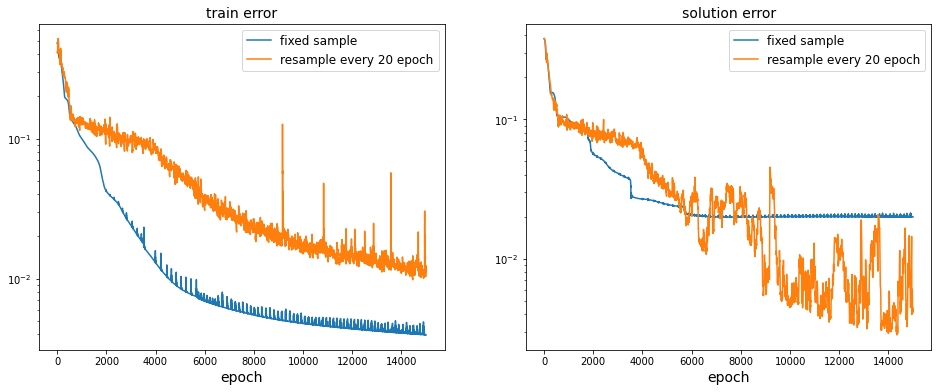

In [9]:
# compare loss evolution for the two cases
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), ncols=2)
ax1.plot(pde_errors0)
ax1.plot(pde_errors1)
ax2.plot(u_errors0)
ax2.plot(u_errors1)
ax1.set_title('train error', fontsize=14)
ax2.set_title('solution error', fontsize=14)
for ax in [ax1, ax2]:
    ax.legend(['fixed sample', f'resample every {resample_period} epoch'], fontsize=12)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_yscale('log')

### Case 3: testing with enforced boundary condition with $(x^2-1)$

In [10]:
net2 = GalerkinFFN(activation, n_hidden, n_nodes, inputs=1).to(device)
net2.load_state_dict(initial_state)
model2 = Burger1DNN(N_init, N_bc, N_pde, net2, device)
optimizer = torch.optim.Adam(net2.parameters())

callbacks = []
callbacks.append(ResamplingHandler(model2, sampling_rate=resample_period))
pde_errors2 = []
callbacks.append(ValueTracker(name='training loss', values=pde_errors2))
u_errors2 = []
callbacks.append(ValidationErrorTracker(model2, mse_loss, 
                                        (sol_x, sol_t, sol_u), errors=u_errors2))
callbacks.append(DiagnosticVerbose(trainer=model2, print_rate=1000, 
                              values={'pde error': pde_errors2, 'solution error': u_errors2}))

In [11]:
model2.train(optimizer, mse_loss, max_epochs, callbacks)

At epoch 0: pde error: 0.5296; solution error: 0.3791; 
At epoch 1000: pde error: 0.1493; solution error: 0.1302; 
At epoch 2000: pde error: 0.1225; solution error: 0.0877; 
At epoch 3000: pde error: 0.0933; solution error: 0.0664; 
At epoch 4000: pde error: 0.0729; solution error: 0.0484; 
At epoch 5000: pde error: 0.0524; solution error: 0.0322; 
At epoch 6000: pde error: 0.0459; solution error: 0.0257; 
At epoch 7000: pde error: 0.0343; solution error: 0.0174; 
At epoch 8000: pde error: 0.0186; solution error: 0.0180; 
At epoch 9000: pde error: 0.0151; solution error: 0.0046; 
At epoch 10000: pde error: 0.0114; solution error: 0.0040; 
At epoch 11000: pde error: 0.0112; solution error: 0.0031; 
At epoch 12000: pde error: 0.0070; solution error: 0.0123; 
At epoch 13000: pde error: 0.0073; solution error: 0.0018; 
At epoch 14000: pde error: 0.0069; solution error: 0.0016; 
At epoch 15000: pde error: 0.0059; solution error: 0.0022; 


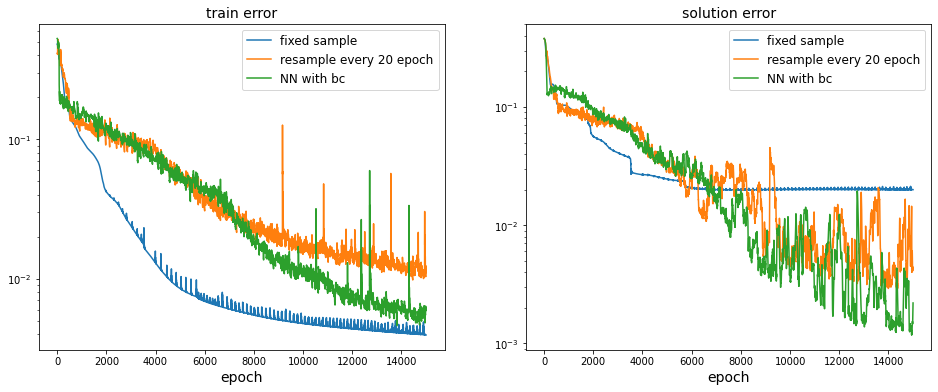

In [12]:
# compare loss evolution for the two cases
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), ncols=2)
ax1.plot(pde_errors0)
ax1.plot(pde_errors1)
ax1.plot(pde_errors2)
ax2.plot(u_errors0)
ax2.plot(u_errors1)
ax2.plot(u_errors2)
ax1.set_title('train error', fontsize=14)
ax2.set_title('solution error', fontsize=14)
for ax in [ax1, ax2]:
    ax.legend(['fixed sample', f'resample every {resample_period} epoch', 
              'NN with bc'], fontsize=12)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_yscale('log')